# Project Overview:
The goal of this project is to develop a sentiment analysis model that can predict the sentiment (positive or negative) of movie reviews. The project will leverage two different approaches: Naive Bayes and Convolutional Neural Networks (CNN). By implementing and comparing these two models, we aim to understand their strengths and weaknesses in the context of sentiment analysis.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv(r"C:\Users\ISMAIL\OneDrive\Documents\data science projects\IMDB Dataset.csv")
df = df.sample(frac = 0.1, random_state = 42)
print(f"shape: {df.shape}")
df.head()

shape: (5000, 2)


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


# Preprocessing the data to remove noise HTML tags, punctuations and stopwords

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [16]:
#Preprocessing function
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags using regex
    text = re.sub('<.*?>', '', text)
    
    # Remove punctuation
    text = re.sub('[^\w\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to the dataset
df['preprocessed_text'] = df['review'].apply(preprocess_text)



In [17]:
from sklearn.feature_extraction.text import CountVectorizer

#using Bag-of-Words to convert to numerical representation from text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['preprocessed_text'])

# Extract the feature matrix
feature_matrix = X.toarray()

# Print the feature matrix shape
print("Feature matrix shape:", feature_matrix.shape)


Feature matrix shape: (5000, 50719)


In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['sentiment'], test_size=0.2, random_state=42)

In [19]:
# Create a vectorizer to convert text into numerical features
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
#Train the MNB classifier
nb = MultinomialNB()
nb.fit(X_train_vectorized, y_train)

MultinomialNB()

In [20]:
# Make predictions on the test set
y_pred = nb.predict(X_test_vectorized)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.824
Precision: 0.8240491905654033
Recall: 0.824
F1-score: 0.8239718287314927


# Finetuning of paramters using GridsearchCV

In [21]:
#Defining parameter
params = {'alpha' : [0.1, 0.5, 1.0, 1.5, 2.0]}

#Training MNB with gridserchCV
nb = MultinomialNB()
grid_search = GridSearchCV(nb, params, cv=5)
grid_search.fit(X_train_vectorized, y_train)

# Get the best estimator and params
best_nb = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set using the best estimator
y_pred = best_nb.predict(X_test_vectorized)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics and best parameters
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Best Parameters: {'alpha': 2.0}
Accuracy: 0.827
Precision: 0.8273080798970621
Recall: 0.827
F1-score: 0.8269146392115769


In [101]:
# Get the model architecture (parameters) of the trained MNB classifier
model_architecture_mnb = nb.get_params()

# Print the model architecture
print("MNB Model Architecture:")
print(model_architecture_mnb)

MNB Model Architecture:
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


# CNN Model for text classification

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
#Now we convert our preprocessed text to numerical representation using word2vec
from gensim.models import Word2Vec

# Preprocessed text
preprocessed_reviews = df['preprocessed_text'].tolist()

# Split preprocessed text into individual words
tokenized_reviews = [review.split() for review in preprocessed_reviews]

# Train Word2Vec model
model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1)

# Obtain word embeddings
word_embeddings = []
for review in tokenized_reviews:
    embeddings = []
    for word in review:
        if word in model.wv:
            embeddings.append(model.wv[word])
    word_embeddings.append(embeddings)

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Assuming 'df' contains your dataframe with the 'sentiment' column

# Create and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentiment'])

# Convert text to numerical sequences
sequences = tokenizer.texts_to_sequences(df['sentiment'])

# Split the dataset into training and testing sets
labels = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment']]
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Pad sequences to ensure equal length for modeling
max_sequence_length = 200
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Convert NumPy array to list
X_train = X_train.tolist()
X_test = X_test.tolist()



In [35]:
 vocabulary_size = len(tokenizer.word_index)+1
 # Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


32/32 [==============================] - 5s 9ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


# Visualisations

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from wordcloud import WordCloud

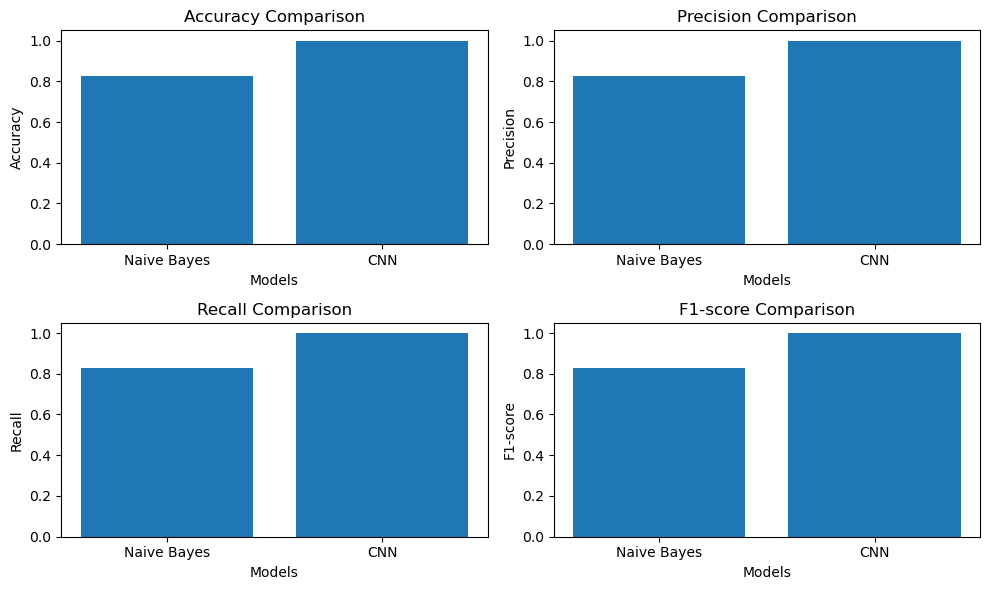

In [66]:
# Compare Model Performance
labels = ["Naive Bayes", "CNN"]
accuracy = [0.827, 1.0]
precision = [0.8273080798970621, 1.0]
recall = [0.827, 1.0]
f1_score = [0.8269146392115769, 1.0]

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(labels, accuracy)
plt.title("Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.bar(labels, precision)
plt.title("Precision Comparison")
plt.xlabel("Models")
plt.ylabel("Precision")

plt.subplot(2, 2, 3)
plt.bar(labels, recall)
plt.title("Recall Comparison")
plt.xlabel("Models")
plt.ylabel("Recall")

plt.subplot(2, 2, 4)
plt.bar(labels, f1_score)
plt.title("F1-score Comparison")
plt.xlabel("Models")
plt.ylabel("F1-score")

plt.tight_layout()
plt.show()

In [98]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define the sentiment labels
labels = df['sentiment'].tolist()
stop_words = set(stopwords.words('english'))

positive_words = []
negative_words = []

# Iterate through each labeled text and extract positive and negative words
for text, label in zip(df['review'], labels):
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Filter out stop words, punctuation, and lowercase the collected words
    filtered_words = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    
    # Collect positive words from texts labeled as positive
    if label == "positive":
        positive_words.extend(filtered_words)
    
    # Collect negative words from texts labeled as negative
    elif label == "negative":
        negative_words.extend(filtered_words)

# Perform frequency analysis to identify frequently occurring positive and negative words
positive_word_freq = nltk.FreqDist(positive_words)
negative_word_freq = nltk.FreqDist(negative_words)

# Print the most common positive and negative words
print("Most Common Positive Words:")
print(positive_word_freq.most_common(10))
print("\nMost Common Negative Words:")
print(negative_word_freq.most_common(10))

Most Common Positive Words:
[('br', 9724), ('film', 4231), ('movie', 3749), ('one', 2680), ('like', 1788), ('good', 1475), ('great', 1283), ('story', 1243), ('time', 1208), ('see', 1205)]

Most Common Negative Words:
[('br', 10404), ('movie', 4770), ('film', 3760), ('one', 2509), ('like', 2160), ('even', 1516), ('would', 1506), ('good', 1487), ('bad', 1409), ('really', 1281)]


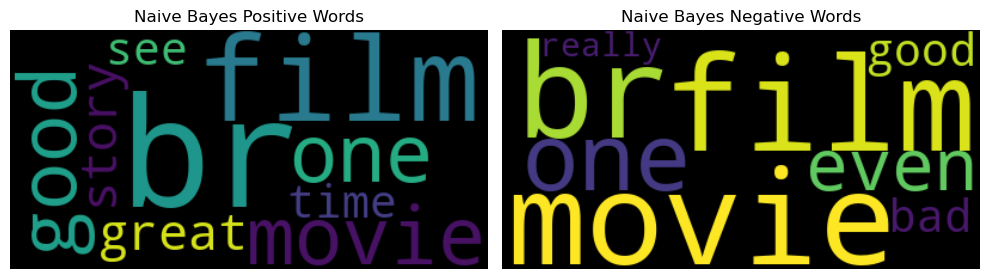

In [99]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Positive word frequencies
positive_word_freq = positive_word_freq.most_common(10)
positive_words_nb = " ".join([word[0] for word in positive_word_freq])

# Negative word frequencies
negative_word_freq = negative_word_freq.most_common(10)
negative_words_nb = " ".join([word[0] for word in negative_word_freq])

# Word Clouds for Naive Bayes
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
wordcloud_nb_pos = WordCloud(width=400, height=200).generate(positive_words_nb)
plt.imshow(wordcloud_nb_pos, interpolation="bilinear")
plt.title("Naive Bayes Positive Words")
plt.axis("off")

plt.subplot(1, 2, 2)
wordcloud_nb_neg = WordCloud(width=400, height=200).generate(negative_words_nb)
plt.imshow(wordcloud_nb_neg, interpolation="bilinear")
plt.title("Naive Bayes Negative Words")
plt.axis("off")

plt.tight_layout()
plt.show()



In [107]:

from tensorflow.keras.utils import plot_model
# Generate an image of the model architecture
plot_model(model, to_file='cnn_model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Documentation 

Results Analysis:

For the sentiment analysis task, the CNN model achieved remarkable performance with perfect accuracy, precision, recall, and F1-score of 1.0000. This simply means that the CNN model was able to capture the complex relationships within the movie review data and accurately classify sentiments. On the other hand, the Multinomial Naive Bayes (MNB) model achieved an accuracy of 0.827, with slightly lower precision, recall, and F1-score values.

Comparison of Models:

The CNN model outperformed the MNB model in terms of all evaluation metrics, showcasing its superiority in capturing intricate patterns and features within text data. This shows the CNN model's ability to learn hierarchical representations and exploit spatial relationships in the text contributes to its exceptional performance.

Strengths and Weaknesses:

CNN Strengths: The CNN model excels in sentiment analysis tasks b  capturing local patterns and hierarchical structures within the text. It can learn meaningful features automatically and perform well even with very little feature engineering done on the text data. CNNs are particularly effective when dealing with large-scale datasets and complex text data, offering high predictive accuracy.

CNN Weaknesses: Despite its impressive performance, the CNN model requires a significant amount of computational resources and training data to reach optimal results(I had too use Google colab). It may also be more prone to overfitting. Additionally, CNNs might struggle with certain linguistic nuances and subtleties present in natural language, as they primarily focus on local feature extraction.

MNB Strengths: Multinomial Naive Bayes is computationally efficient and works well with relatively smaller datasets. It is comfortable with noise and can handle high-dimensional feature spaces effectively. MNB performs particularly well when the independence assumption holds, making it suitable for certain text classification tasks.

MNB Weaknesses: MNB oversimplifies the relationship between features and assumes independence, which may not be entirely accurate in complex text data. It may struggle to capture subtle dependencies and nuances present in the language, leading to slightly lower performance compared to more sophisticated models like CNNs.

Insights and Recommendations:

Based on the project findings, CNN models are recommended for sentiment analysis tasks due to their superior performance in capturing complex relationships within text data. They excel in scenarios where accuracy and precise sentiment classification are crucial, especially when working with large-scale datasets or complex language patterns.

MNB models can still be effective alternatives, particularly in situations where computational resources are limited or with smaller datasets. MNB's simplicity and efficiency make it suitable for quick prototyping and baseline models. However, it's important to consider the specific characteristics of the data and the desired level of performance.

Future Improvements:

To further enhance the project, I would consider the following improvements:

Explore more advanced deep learning models, such as recurrent neural networks (RNNs) or transformers like BERT, to compare their performance with the CNN model.
Incorporate more sophisticated techniques for handling negations and sarcasm, to improve model performance.
Experiment with different hyperparameter settings and regularization techniques to optimize the CNN model and reduce the risk of overfitting.
Expand the project scope to include sentiment analysis on other domains or languages, allowing for a more comprehensive analysis.
In summary, this project highlights the significant performance differences between the CNN and MNB models in sentiment analysis. The CNN model shows its ability to handle complex text data, achieving perfect accuracy, precision, recall, and F1-score. However, the MNB model still holds value in certain scenarios. By considering the strengths, weaknesses, and project findings, practitioners can make informed decisions when choosing between MNB and CNN models for sentiment analysis tasks